# XGBoost Land Cover Classification

This notebook performs supervised land cover classification using XGBoost with class balancing for Arctic/tundra vegetation mapping.

**Workflow:**
1. Load hyperspectral imagery, Synthetic Aperture Radar (polSAR) and reference land cover data points
2. Train XGBoost classifier with undersampling to handle class imbalance
3. Predict land cover on full imagery
4. Visualize results with interactive map
5. Export to GeoTIFF with embedded colormap for ArcGIS

## 1. Configuration & Imports

All imports and configurable parameters are defined here. Modify these settings to:
- Change input/output file paths
- Select which bands to use for classification
- Adjust class names and balancing parameters

In [1]:
# IMPORTS
import numpy as np
import xarray as xr
import rioxarray
import rasterio
from rasterio.enums import ColorInterp, Resampling
from glob import glob
from datetime import datetime
import os

import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import uniform, randint, loguniform

import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import geoviews as gv
from geoviews import tile_sources as gvts
from bokeh.models import HoverTool, CustomJSHover

hv.extension('bokeh')

# =============================================================================
# CONFIGURATION
# =============================================================================

TARGET_CRS = "EPSG:3857"
LANDCOVER_PATH = "input/LandcoverRef.tif"
OUTPUT_DIR = "output"

# INPUT DATASETS
INPUT_DATASETS = [
    {
        'enabled': True,
        'name': 'Hyperspectral MNF',
        'short': 'FMNF',
        'path': 'input/Wyvern Tiles Nohistmatch FMNF',
        'pattern': '/*.dat',
        'bands': [1, 2, 3],
    },
    {
        'enabled': True,
        'name': 'SAR Pauli',
        'short': 'SAR',
        'path': 'input/SAR Pauli',
        'pattern': '/*.tif',
        'bands': [1, 2, 3],
        'nodata': 0,
    },
]

# SPECTRAL INDICES SOURCE
SPECTRAL_INDICES_SOURCE = {
    'enabled': False,
    'name': 'Hyperspectral for Indices',
    'short': 'IDX',
    'path': 'input/Wyvern Tiles MNF3C',
    'pattern': '/*.dat',
}

# SPECTRAL INDICES (Band wavelengths: B3=Blue, B9=Green, B15=Red, B17=RedEdge, B31=NIR)
SPECTRAL_INDICES = {
    'NDVI': {'enabled': True, 'bands': [31, 17], 'formula': 'normalized_difference'},
    'NDWI': {'enabled': True, 'bands': [9, 31], 'formula': 'normalized_difference'},
    'BSI':  {'enabled': True, 'bands': [15, 3, 31, 9], 'formula': 'bsi'},
}

# FEATURE STANDARDIZATION
# Options: None, 'standard' (zero mean, unit variance), 'minmax' (scale to 0-1)
# Note: XGBoost is tree-based and generally doesn't require standardization,
# but it can help when features have very different scales or for interpretability.
STANDARDIZE_FEATURES = None  # Set to 'standard' or 'minmax' to enable

# XGBOOST PARAMETERS
XGBOOST_PARAMS = {
    'n_estimators': 400,
    'max_depth': 11,
    'learning_rate': 0.0102,
    'min_child_weight': 1,
    'subsample': 0.7169,
    'colsample_bytree': 0.8470,
    'gamma': 0.0448,
    'reg_alpha': 0.0685,
    'reg_lambda': 0.1519,
    'random_state': 42,
    'n_jobs': -1,
    'device': 'cuda'
}

# Parameters to include in output filename
XGBOOST_PARAMS_IN_FILENAME = {
    'n_estimators': False,
    'max_depth': False,
    'learning_rate': False,
    'min_child_weight': False,
    'subsample': False,
    'colsample_bytree': False,
}

# RANDOM PARAMETER SEARCH
RANDOM_SEARCH_ENABLED = False

RANDOM_SEARCH_CONFIG = {
    'n_iter': 20,
    'cv': 3,
    'scoring': 'accuracy',
    'random_state': 42,
    'verbose': 2,
}

RANDOM_SEARCH_PARAM_DIST = {
    'classifier__n_estimators': [100, 200, 400, 800, 1200, 1600],  # Extended range to find overfitting point
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': loguniform(0.01, 0.3),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': loguniform(1e-3, 0.5),
    'classifier__reg_alpha': loguniform(1e-3, 1),
    'classifier__reg_lambda': loguniform(0.1, 2),
}

# CLASS BALANCING
BALANCE_MULTIPLIER = 5

# VALIDATION SPLIT FOR LEARNING CURVES
VALIDATION_SPLIT = 0.2

# EARLY STOPPING
EARLY_STOPPING = {
    'enabled': True,
    'rounds': 20,  # Stop if no improvement for this many rounds
}

# LAND COVER CLASSES (0-indexed for XGBoost, raster values are 1-10)
CLASS_NAMES = {
    0: 'DST', 1: 'TST', 2: 'LTDST', 3: 'OST', 4: 'Wet',
    5: 'Waterbody', 6: 'PBHV', 7: 'Barren', 8: 'SASH', 9: 'BRN'
}

# Initialize run log
RUN_TIMESTAMP = datetime.now()
RUN_LOG = {
    'timestamp': RUN_TIMESTAMP.strftime('%Y-%m-%d %H:%M:%S'),
    'sections': []
}

# Store learning curves for plotting
LEARNING_CURVES = {}

# Store scaler for prediction (will be set during training if standardization enabled)
FEATURE_SCALER = None

def log_section(title, content):
    RUN_LOG['sections'].append({'title': title, 'content': content})

# BUILD OUTPUT FILENAME
_parts = [ds['short'] for ds in INPUT_DATASETS if ds.get('enabled', True)]
_enabled_indices = [name for name, cfg in SPECTRAL_INDICES.items() if cfg.get('enabled', True)]
if SPECTRAL_INDICES_SOURCE['enabled'] and _enabled_indices:
    _parts.append(f"{SPECTRAL_INDICES_SOURCE['short']}({'+'.join(_enabled_indices)})")

_xgb_parts = []
_param_abbrev = {'n_estimators': 'n', 'max_depth': 'd', 'learning_rate': 'lr',
                 'min_child_weight': 'mcw', 'subsample': 'ss', 'colsample_bytree': 'cs'}
for param, include in XGBOOST_PARAMS_IN_FILENAME.items():
    if include and param in XGBOOST_PARAMS:
        abbrev = _param_abbrev.get(param, param[:3])
        value = XGBOOST_PARAMS[param]
        if isinstance(value, float):
            value = f"{value:g}"
        _xgb_parts.append(f"{abbrev}{value}")

if _xgb_parts:
    _parts.append(f"XGB({'_'.join(_xgb_parts)})")

OUTPUT_BASE = f"LC_{'_'.join(_parts)}_{RUN_TIMESTAMP.strftime('%m%d_%H%M')}"
RUN_OUTPUT_DIR = f"{OUTPUT_DIR}/{OUTPUT_BASE}"
OUTPUT_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}.tif"
LOG_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}.txt"
CURVES_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}_learning_curves.png"

print(f"Configuration loaded. Output folder: {RUN_OUTPUT_DIR}")
os.makedirs(RUN_OUTPUT_DIR, exist_ok=True)

c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


Configuration loaded. Output folder: output/LC_FMNF_SAR_0114_1134


## 2. Load Training Data

Load all input datasets and the reference land cover raster. 

**Native Grid Approach:** To avoid reprojection artifacts (striping), features are kept in their native CRS. Only the landcover reference is reprojected to match the primary hyperspectral grid.

**Band selection:** Only the specified bands from each dataset are used as features.

In [2]:
def get_dataset_info(path, pattern):
    files = glob(path + pattern)
    if not files:
        return None
    da = xr.open_dataarray(files[0], engine='rasterio')
    return {'crs': str(da.rio.crs), 'resolution': da.rio.resolution(), 'shape': da.shape, 'files': len(files)}

# Collect input data metadata
input_log = []
input_log.append("Landcover Reference:")
lc_info = get_dataset_info('input', '/LandcoverRef.tif')
if lc_info:
    input_log.append(f"  Path: {LANDCOVER_PATH}")
    input_log.append(f"  CRS: {lc_info['crs']}, Resolution: {lc_info['resolution']}, Shape: {lc_info['shape']}")

for config in INPUT_DATASETS:
    if not config.get('enabled', True):
        continue
    info = get_dataset_info(config['path'], config['pattern'])
    if info:
        input_log.append(f"\n{config['name']}:")
        input_log.append(f"  Path: {config['path']}{config['pattern']}")
        input_log.append(f"  Bands: {config['bands']}")
        input_log.append(f"  CRS: {info['crs']}, Resolution: {info['resolution']}, Shape: {info['shape']}")
        if 'nodata' in config:
            input_log.append(f"  NoData: {config['nodata']}")

if SPECTRAL_INDICES_SOURCE['enabled']:
    idx_info = get_dataset_info(SPECTRAL_INDICES_SOURCE['path'], SPECTRAL_INDICES_SOURCE['pattern'])
    if idx_info:
        input_log.append(f"\nSpectral Indices Source:")
        input_log.append(f"  Path: {SPECTRAL_INDICES_SOURCE['path']}{SPECTRAL_INDICES_SOURCE['pattern']}")
        input_log.append(f"  CRS: {idx_info['crs']}, Resolution: {idx_info['resolution']}, Shape: {idx_info['shape']}")
        input_log.append(f"  Indices: {[k for k,v in SPECTRAL_INDICES.items() if v.get('enabled')]}")

log_section("INPUT DATA", "\n".join(input_log))

# Load primary dataset as reference grid
def load_raster_tiles(path, pattern, bands_to_select=None):
    files = sorted(glob(path + pattern))
    if not files:
        return None
    
    if len(files) == 1:
        da = xr.open_dataarray(files[0], engine='rasterio')
        if bands_to_select is not None and 'band' in da.dims:
            da = da.sel(band=bands_to_select)
        return da
    
    def preprocess(ds):
        da = ds['band_data'] if 'band_data' in ds else ds.to_array().squeeze('variable')
        if bands_to_select is not None and 'band' in da.dims:
            da = da.sel(band=bands_to_select)
        da.attrs = {}
        return da.to_dataset(name='data')
    
    ds = xr.open_mfdataset(files, engine='rasterio', combine='by_coords',
                           preprocess=preprocess, combine_attrs='drop_conflicts')
    return ds['data']

enabled_datasets = [ds for ds in INPUT_DATASETS if ds.get('enabled', True)]
if not enabled_datasets:
    raise ValueError("No enabled input datasets!")
primary_config = enabled_datasets[0]

bands_to_load = primary_config['bands'] if primary_config['bands'] != 'all' else None
primary_da = load_raster_tiles(primary_config['path'], primary_config['pattern'], bands_to_select=bands_to_load)

reference_grid = primary_da.isel(band=0) if 'band' in primary_da.dims else primary_da
NATIVE_CRS = str(reference_grid.rio.crs)

# Reproject landcover to native grid
lc_ds_orig = xr.open_dataarray(LANDCOVER_PATH, engine='rasterio')
lc_ds = lc_ds_orig.rio.reproject_match(reference_grid, resampling=Resampling.nearest)

# Load all datasets
def load_dataset_native(config, reference_da):
    name = config.get('name', config['path'])
    files = glob(config['path'] + config['pattern'])
    if not files:
        raise FileNotFoundError(f"No files found for {name}")
    
    bands_to_load = config['bands'] if config['bands'] != 'all' else None
    da = load_raster_tiles(config['path'], config['pattern'], bands_to_select=bands_to_load)
    
    if 'nodata' in config:
        da = da.where(da != config['nodata'])
    
    if da.rio.crs != reference_da.rio.crs:
        da = da.rio.reproject_match(reference_da, resampling=Resampling.bilinear)
    
    return da

def calculate_spectral_indices_native(source_config, indices_config, reference_da):
    if not source_config.get('enabled', False):
        return [], []
    
    enabled_indices = {name: cfg for name, cfg in indices_config.items() if cfg.get('enabled', True)}
    if not enabled_indices:
        return [], []
    
    files = glob(source_config['path'] + source_config['pattern'])
    if not files:
        return [], []
    
    required_bands = sorted(set(b for cfg in enabled_indices.values() for b in cfg['bands']))
    hs_da = load_raster_tiles(source_config['path'], source_config['pattern'], bands_to_select=required_bands)
    
    if hs_da.rio.crs != reference_da.rio.crs or hs_da.shape[-2:] != reference_da.shape[-2:]:
        hs_da = hs_da.rio.reproject_match(reference_da, resampling=Resampling.bilinear)
    
    indices_data, indices_names = [], []
    
    for idx_name, idx_config in enabled_indices.items():
        bands = idx_config['bands']
        formula = idx_config['formula']
        
        try:
            if formula == 'normalized_difference':
                b1 = hs_da.sel(band=bands[0]).astype('float32')
                b2 = hs_da.sel(band=bands[1]).astype('float32')
                result = xr.where((b1 + b2) != 0, (b1 - b2) / (b1 + b2), np.nan)
            elif formula == 'bsi':
                red, blue, nir, green = [hs_da.sel(band=b).astype('float32') for b in bands]
                num = (red + blue) - (nir + green)
                denom = (red + blue) + (nir + green)
                result = xr.where(denom != 0, num / denom, np.nan)
            else:
                continue
            
            result = result.drop_vars('band', errors='ignore').squeeze()
            indices_data.append(result)
            indices_names.append(idx_name)
        except Exception as e:
            print(f"  Failed {idx_name}: {e}")
    
    return indices_data, indices_names

# Load all features
all_features, feature_names = [], []

for config in INPUT_DATASETS:
    if not config.get('enabled', True):
        continue
    try:
        da = load_dataset_native(config, reference_grid)
        if 'band' in da.dims:
            for band in da.band.values:
                all_features.append(da.sel(band=band).drop_vars('band', errors='ignore'))
                feature_names.append(f"{config['name']}_band{band}")
        else:
            all_features.append(da.drop_vars('band', errors='ignore'))
            feature_names.append(config['name'])
    except Exception as e:
        print(f"Failed to load {config['name']}: {e}")

indices_data, indices_names = calculate_spectral_indices_native(SPECTRAL_INDICES_SOURCE, SPECTRAL_INDICES, reference_grid)
all_features.extend(indices_data)
feature_names.extend(indices_names)

# Stack features
stacked_ds = xr.Dataset({name: feat.squeeze() for name, feat in zip(feature_names, all_features)})
stacked_ds['landcover'] = lc_ds.squeeze().drop_vars('band', errors='ignore')
stacked_ds = stacked_ds.rio.write_crs(NATIVE_CRS)

# Coverage statistics
total_pixels = int(np.prod([stacked_ds.dims[d] for d in ['y', 'x']]))
lc_valid = stacked_ds['landcover'].notnull()
features_valid = xr.concat([stacked_ds[name].notnull() for name in feature_names], dim='feature').all(dim='feature')
both_valid = lc_valid & features_valid

feature_log = [f"Native CRS: {NATIVE_CRS}", f"Resolution: {reference_grid.rio.resolution()}", f"Shape: {reference_grid.shape}", ""]
feature_log.append("Features:")
for name in feature_names:
    feature_log.append(f"  - {name}")
feature_log.append("")
feature_log.append(f"Total pixels: {total_pixels:,}")
feature_log.append(f"Valid for training: {int(both_valid.sum().values):,} ({100*both_valid.sum().values/total_pixels:.1f}%)")
log_section("FEATURE STACK", "\n".join(feature_log))

print(f"Loaded {len(feature_names)} features. Valid training pixels: {int(both_valid.sum().values):,}")
stacked_ds

C:\Users\lili0243\AppData\Local\Temp\ipykernel_30632\289532464.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_pixels = int(np.prod([stacked_ds.dims[d] for d in ['y', 'x']]))


Loaded 6 features. Valid training pixels: 475,206


<xarray.Dataset> Size: 3GB
Dimensions:                  (x: 6992, y: 13004)
Coordinates:
  * x                        (x) float64 56kB -133.7 -133.7 ... -132.8 -132.8
  * y                        (y) float64 104kB 69.4 69.4 69.4 ... 68.82 68.82
    spatial_ref              int64 8B 0
Data variables:
    Hyperspectral MNF_band1  (y, x) float32 364MB nan nan nan ... nan nan nan
    Hyperspectral MNF_band2  (y, x) float32 364MB nan nan nan ... nan nan nan
    Hyperspectral MNF_band3  (y, x) float32 364MB nan nan nan ... nan nan nan
    SAR Pauli_band1          (y, x) float32 364MB nan nan nan ... nan nan nan
    SAR Pauli_band2          (y, x) float32 364MB nan nan nan ... nan nan nan
    SAR Pauli_band3          (y, x) float32 364MB nan nan nan ... nan nan nan
    landcover                (y, x) float32 364MB nan nan nan ... nan nan nan

## 3. Train XGBoost Classifier

Train an XGBoost classifier with class balancing using random undersampling. 

**Balancing strategy:** Majority classes are capped at `BALANCE_MULTIPLIER × minority_class_size` to prevent the model from being biased towards dominant classes while retaining enough samples for learning.

**Evaluation:** 5-fold stratified cross-validation is performed before final training to estimate model performance.

In [3]:
# Prepare training data
X = np.stack([stacked_ds[name].values.flatten() for name in feature_names], axis=1)
y = stacked_ds['landcover'].values.flatten()

# Filter valid pixels: not NaN, not 0 (NoData), and within valid class range (1-10)
valid_idx = ~np.isnan(y) & ~np.isnan(X).any(axis=1) & (y >= 1) & (y <= 10)
X, y = X[valid_idx], y[valid_idx].astype(int) - 1

# Optional feature standardization
if STANDARDIZE_FEATURES:
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    if STANDARDIZE_FEATURES == 'standard':
        FEATURE_SCALER = StandardScaler()
        print("Applying StandardScaler (zero mean, unit variance)...")
    elif STANDARDIZE_FEATURES == 'minmax':
        FEATURE_SCALER = MinMaxScaler()
        print("Applying MinMaxScaler (scale to 0-1)...")
    else:
        raise ValueError(f"Unknown standardization method: {STANDARDIZE_FEATURES}")
    
    # Fit on training data and transform
    X = FEATURE_SCALER.fit_transform(X)
    
    # Log feature statistics after scaling
    print(f"  Feature means: {X.mean(axis=0).round(4)}")
    print(f"  Feature stds:  {X.std(axis=0).round(4)}")
else:
    FEATURE_SCALER = None

# Class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist = [f"Training samples: {len(y):,}, Features: {len(feature_names)}", ""]
if STANDARDIZE_FEATURES:
    class_dist.append(f"Feature Standardization: {STANDARDIZE_FEATURES}")
    class_dist.append("")
class_dist.append("Class Distribution:")
for cls, count in zip(unique, counts):
    class_dist.append(f"  {CLASS_NAMES[cls]:12s}: {count:6,} ({100*count/len(y):5.1f}%)")
log_section("CLASS DISTRIBUTION", "\n".join(class_dist))

# Sampling strategy
def make_sampling_strategy(multiplier):
    def strategy(y):
        unique, counts = np.unique(y, return_counts=True)
        max_samples = counts.min() * multiplier
        return {cls: min(count, max_samples) for cls, count in zip(unique, counts)}
    return strategy

# Training
training_log = []
overfitting_log = []

if RANDOM_SEARCH_ENABLED:
    print(f"Running randomized parameter search ({RANDOM_SEARCH_CONFIG['n_iter']} iterations, {RANDOM_SEARCH_CONFIG['cv']}-fold CV)...")
    training_log.append("Mode: Randomized Parameter Search")
    training_log.append(f"Iterations: {RANDOM_SEARCH_CONFIG['n_iter']}")
    training_log.append(f"CV Folds: {RANDOM_SEARCH_CONFIG['cv']}")
    training_log.append(f"Scoring: {RANDOM_SEARCH_CONFIG['scoring']}")
    training_log.append("")
    
    pipeline = Pipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)),
        ('classifier', xgb.XGBClassifier(**XGBOOST_PARAMS))
    ])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=RANDOM_SEARCH_PARAM_DIST,
        n_iter=RANDOM_SEARCH_CONFIG['n_iter'],
        cv=StratifiedKFold(n_splits=RANDOM_SEARCH_CONFIG['cv'], shuffle=True, random_state=42),
        scoring=RANDOM_SEARCH_CONFIG['scoring'],
        random_state=RANDOM_SEARCH_CONFIG['random_state'],
        verbose=RANDOM_SEARCH_CONFIG['verbose'],
        n_jobs=1, return_train_score=True
    )
    random_search.fit(X, y)
    
    # Log all CV results
    training_log.append("All Parameter Combinations Tested:")
    training_log.append("-" * 80)
    cv_results = random_search.cv_results_
    sorted_idx = np.argsort(cv_results['rank_test_score'])
    for rank_i, i in enumerate(sorted_idx):
        params_str = ", ".join(f"{k.replace('classifier__', '')}={v:.4f}" if isinstance(v, float) else f"{k.replace('classifier__', '')}={v}" 
                               for k, v in cv_results['params'][i].items())
        training_log.append(f"#{rank_i+1} (score={cv_results['mean_test_score'][i]:.4f} +/- {cv_results['std_test_score'][i]:.4f})")
        training_log.append(f"    {params_str}")
    
    training_log.append("")
    training_log.append("Best Parameters:")
    best_params = {}
    for param, value in sorted(random_search.best_params_.items()):
        param_name = param.replace('classifier__', '')
        best_params[param_name] = value
        training_log.append(f"  {param_name}: {value:.4f}" if isinstance(value, float) else f"  {param_name}: {value}")
    training_log.append(f"\nBest CV Score: {random_search.best_score_:.4f}")
    
    # Overfitting analysis from CV results
    best_idx = random_search.best_index_
    train_score = cv_results['mean_train_score'][best_idx]
    test_score = cv_results['mean_test_score'][best_idx]
    train_std = cv_results['std_train_score'][best_idx]
    test_std = cv_results['std_test_score'][best_idx]
    overfit_gap = train_score - test_score
    
    overfitting_log.append("Cross-Validation Scores (Best Model):")
    overfitting_log.append(f"  Train Score: {train_score:.4f} (+/- {train_std:.4f})")
    overfitting_log.append(f"  Test Score:  {test_score:.4f} (+/- {test_std:.4f})")
    overfitting_log.append(f"  Overfit Gap: {overfit_gap:.4f}")
    overfitting_log.append("")
    
    if overfit_gap > 0.1:
        overfitting_log.append("  WARNING: Large train-test gap suggests overfitting")
    elif overfit_gap > 0.05:
        overfitting_log.append("  CAUTION: Moderate train-test gap")
    else:
        overfitting_log.append("  OK: Train-test gap is acceptable")
    
    for param, value in best_params.items():
        if param in XGBOOST_PARAMS:
            XGBOOST_PARAMS[param] = value
    
    y_pred_cv = random_search.predict(X)
    cv_accuracy = random_search.best_score_
    
    training_log.append("")
    training_log.append("Classification Report (Best Model):")
    training_log.append(classification_report(y, y_pred_cv, labels=unique, target_names=[CLASS_NAMES[c] for c in unique]))

else:
    print("Running 5-fold cross-validation...")
    training_log.append("Mode: 5-Fold Cross-Validation")
    training_log.append("")
    
    pipeline = Pipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)),
        ('classifier', xgb.XGBClassifier(**XGBOOST_PARAMS))
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv)
    cv_accuracy = (y_pred_cv == y).mean()
    
    training_log.append(f"CV Accuracy: {cv_accuracy:.4f}")
    training_log.append("")
    training_log.append("XGBoost Parameters Used:")
    for param, value in XGBOOST_PARAMS.items():
        if param not in ['random_state', 'n_jobs']:
            training_log.append(f"  {param}: {value}")
    training_log.append("")
    training_log.append("Classification Report (Out-of-Fold):")
    training_log.append(classification_report(y, y_pred_cv, labels=unique, target_names=[CLASS_NAMES[c] for c in unique]))
    
    pipeline.fit(X, y)

# Train final model with eval_set for learning curves (and early stopping if enabled)
print("Training model with learning curve tracking...")
undersampler = RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_resampled
)

# Set early stopping rounds if enabled
early_stop_rounds = EARLY_STOPPING['rounds'] if EARLY_STOPPING['enabled'] else None
diagnostic_params = {**XGBOOST_PARAMS, 'early_stopping_rounds': early_stop_rounds}
clf_diagnostic = xgb.XGBClassifier(**diagnostic_params)
clf_diagnostic.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# Extract learning curves
results = clf_diagnostic.evals_result()
LEARNING_CURVES['train_error'] = results['validation_0']['mlogloss']
LEARNING_CURVES['val_error'] = results['validation_1']['mlogloss']
LEARNING_CURVES['n_estimators'] = len(LEARNING_CURVES['train_error'])

# Determine optimal n_estimators from early stopping or learning curves
if EARLY_STOPPING['enabled']:
    optimal_n_estimators = clf_diagnostic.best_iteration + 1
    LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
    print(f"Early stopping: optimal n_estimators = {optimal_n_estimators}")
else:
    # Find minimum validation loss epoch
    min_val_idx = np.argmin(LEARNING_CURVES['val_error'])
    optimal_n_estimators = min_val_idx + 1
    LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators

# Calculate additional metrics using diagnostic model
train_pred = clf_diagnostic.predict(X_train)
val_pred = clf_diagnostic.predict(X_val)
train_acc = (train_pred == y_train).mean()
val_acc = (val_pred == y_val).mean()
full_train_pred = clf_diagnostic.predict(X_resampled)
full_train_acc = (full_train_pred == y_resampled).mean()

overfitting_log.append("")
overfitting_log.append("Final Model Training Metrics:")
overfitting_log.append(f"  Balanced dataset size: {len(y_resampled):,}")
overfitting_log.append(f"  Train split: {len(y_train):,} ({100*(1-VALIDATION_SPLIT):.0f}%)")
overfitting_log.append(f"  Validation split: {len(y_val):,} ({100*VALIDATION_SPLIT:.0f}%)")
overfitting_log.append("")
overfitting_log.append(f"  Train Accuracy: {train_acc:.4f}")
overfitting_log.append(f"  Validation Accuracy: {val_acc:.4f}")
overfitting_log.append(f"  Overfit Gap: {train_acc - val_acc:.4f}")
overfitting_log.append("")

# Learning curve analysis
final_train_loss = LEARNING_CURVES['train_error'][-1]
final_val_loss = LEARNING_CURVES['val_error'][-1]
min_val_loss = min(LEARNING_CURVES['val_error'])
min_val_epoch = LEARNING_CURVES['val_error'].index(min_val_loss) + 1

overfitting_log.append("Learning Curve Analysis:")
overfitting_log.append(f"  Final Train Loss: {final_train_loss:.4f}")
overfitting_log.append(f"  Final Val Loss: {final_val_loss:.4f}")
overfitting_log.append(f"  Best Val Loss: {min_val_loss:.4f} (epoch {min_val_epoch})")
overfitting_log.append(f"  Loss Gap: {final_val_loss - final_train_loss:.4f}")

if EARLY_STOPPING['enabled']:
    overfitting_log.append(f"  Early Stopping: enabled (patience={EARLY_STOPPING['rounds']})")
    overfitting_log.append(f"  Optimal n_estimators: {LEARNING_CURVES['optimal_n_estimators']}")
elif min_val_epoch < LEARNING_CURVES['n_estimators'] * 0.7:
    overfitting_log.append(f"  NOTE: Val loss minimum at epoch {min_val_epoch}/{LEARNING_CURVES['n_estimators']}, consider early stopping")

# Confusion matrix for validation set
cm = confusion_matrix(y_val, val_pred, labels=unique)
overfitting_log.append("")
overfitting_log.append("Per-Class Validation Accuracy:")
for i, cls in enumerate(unique):
    class_total = cm[i].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    overfitting_log.append(f"  {CLASS_NAMES[cls]:12s}: {class_acc:.3f} ({class_correct}/{class_total})")

# Retrain final model on FULL balanced dataset with optimal n_estimators
print(f"Retraining final model on full balanced dataset (n_estimators={LEARNING_CURVES['optimal_n_estimators']})...")
final_params_full = {k: v for k, v in XGBOOST_PARAMS.items() if k != 'early_stopping_rounds'}
final_params_full['n_estimators'] = LEARNING_CURVES['optimal_n_estimators']
clf = xgb.XGBClassifier(**final_params_full)
clf.fit(X_resampled, y_resampled, verbose=False)

training_log.append(f"\nBalanced Training Set: {len(y_resampled):,} samples (multiplier={BALANCE_MULTIPLIER})")
training_log.append(f"Final model: n_estimators={LEARNING_CURVES['optimal_n_estimators']} (from {'early stopping' if EARLY_STOPPING['enabled'] else 'best val loss'})")
training_log.append("Final model retrained on 100% of balanced data for prediction.")
training_log.append("")
training_log.append("Feature Importance:")
for idx in np.argsort(clf.feature_importances_)[::-1]:
    training_log.append(f"  {feature_names[idx]:30s}: {clf.feature_importances_[idx]:.4f}")

log_section("MODEL TRAINING", "\n".join(training_log))
log_section("OVERFITTING ANALYSIS", "\n".join(overfitting_log))

print(f"Training complete. CV Accuracy: {cv_accuracy:.4f}, Val Accuracy: {val_acc:.4f}")

Running 5-fold cross-validation...


c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:36:16] WARNING: D:\bld\xgboost-split_1744329000128\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training model with learning curve tracking...
Early stopping: optimal n_estimators = 400
Retraining final model on full balanced dataset (n_estimators=400)...
Training complete. CV Accuracy: 0.9853, Val Accuracy: 0.8535


## 3.1 Learning Curves & Overfitting Analysis

Visualize training vs validation error to assess model behavior:
- **Converging curves**: Good generalization
- **Diverging curves**: Overfitting (reduce complexity, increase regularization)
- **Both high**: Underfitting (increase complexity, more features)

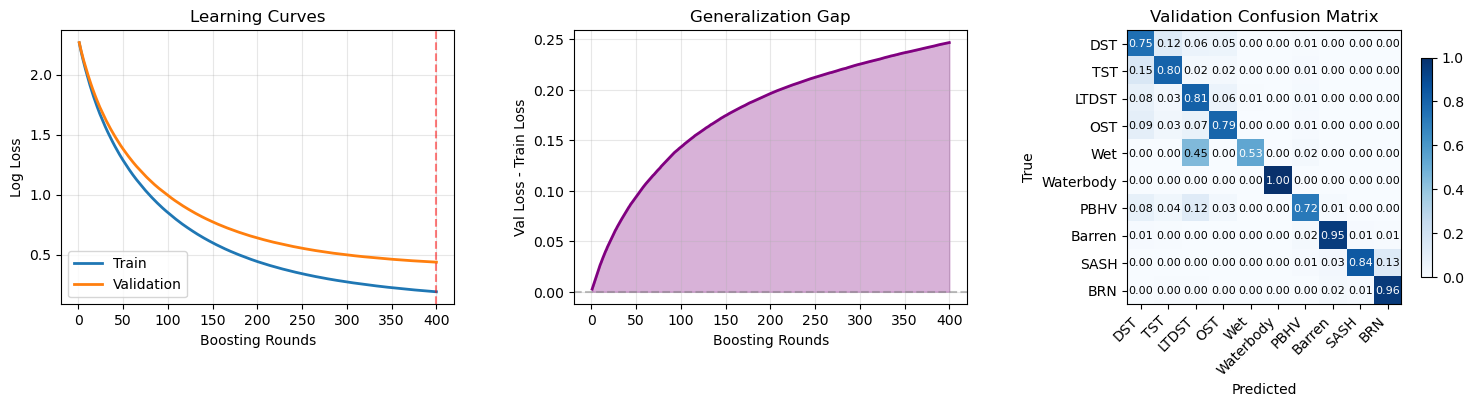

Final Train Loss: 0.1916
Final Val Loss: 0.4384
Generalization Gap: 0.2468
Best Val Loss: 0.4384 at epoch 400


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Learning curves (loss)
ax1 = axes[0]
epochs = range(1, LEARNING_CURVES['n_estimators'] + 1)
ax1.plot(epochs, LEARNING_CURVES['train_error'], label='Train', linewidth=2)
ax1.plot(epochs, LEARNING_CURVES['val_error'], label='Validation', linewidth=2)
ax1.set_xlabel('Boosting Rounds')
ax1.set_ylabel('Log Loss')
ax1.set_title('Learning Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

min_val_idx = np.argmin(LEARNING_CURVES['val_error'])
ax1.axvline(x=min_val_idx + 1, color='red', linestyle='--', alpha=0.5, label=f'Best val @ {min_val_idx+1}')

# Train-Val gap over time
ax2 = axes[1]
gap = np.array(LEARNING_CURVES['val_error']) - np.array(LEARNING_CURVES['train_error'])
ax2.plot(epochs, gap, color='purple', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.fill_between(epochs, 0, gap, alpha=0.3, color='purple')
ax2.set_xlabel('Boosting Rounds')
ax2.set_ylabel('Val Loss - Train Loss')
ax2.set_title('Generalization Gap')
ax2.grid(True, alpha=0.3)

# Confusion matrix heatmap
ax3 = axes[2]
cm = confusion_matrix(y_val, val_pred, labels=unique)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im = ax3.imshow(cm_normalized, cmap='Blues', vmin=0, vmax=1)
ax3.set_xticks(range(len(unique)))
ax3.set_yticks(range(len(unique)))
ax3.set_xticklabels([CLASS_NAMES[c] for c in unique], rotation=45, ha='right')
ax3.set_yticklabels([CLASS_NAMES[c] for c in unique])
ax3.set_xlabel('Predicted')
ax3.set_ylabel('True')
ax3.set_title('Validation Confusion Matrix')
plt.colorbar(im, ax=ax3, shrink=0.8)

for i in range(len(unique)):
    for j in range(len(unique)):
        color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax3.text(j, i, f'{cm_normalized[i, j]:.2f}', ha='center', va='center', color=color, fontsize=8)

plt.tight_layout()
plt.savefig(CURVES_PATH, dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
final_gap = LEARNING_CURVES['val_error'][-1] - LEARNING_CURVES['train_error'][-1]
print(f"Final Train Loss: {LEARNING_CURVES['train_error'][-1]:.4f}")
print(f"Final Val Loss: {LEARNING_CURVES['val_error'][-1]:.4f}")
print(f"Generalization Gap: {final_gap:.4f}")
print(f"Best Val Loss: {min(LEARNING_CURVES['val_error']):.4f} at epoch {min_val_idx + 1}")

## 4. Predict on Full Imagery

Apply the trained classifier to predict land cover for all pixels where input data exists (regardless of whether land cover reference is available).

In [5]:
pred_data = np.stack([stacked_ds[name].values for name in feature_names], axis=0)
n_bands, ny, nx = pred_data.shape
pixels = pred_data.reshape(n_bands, -1).T

valid_mask = ~np.isnan(pixels).any(axis=1)

# Apply same standardization as training (if enabled)
pixels_to_predict = pixels[valid_mask]
if FEATURE_SCALER is not None:
    pixels_to_predict = FEATURE_SCALER.transform(pixels_to_predict)
    print(f"Applied {STANDARDIZE_FEATURES} scaling to prediction data")

predictions = np.full(ny * nx, np.nan, dtype=np.float32)
if valid_mask.sum() > 0:
    predictions[valid_mask] = clf.predict(pixels_to_predict).astype(np.float32) + 1

prediction_da = xr.DataArray(
    predictions.reshape(ny, nx),
    dims=['y', 'x'],
    coords={'y': stacked_ds.coords['y'], 'x': stacked_ds.coords['x']},
    name='landcover_prediction'
).rio.write_crs(lc_ds.rio.crs)

# Log prediction stats
pred_log = [f"Valid pixels predicted: {valid_mask.sum():,} / {len(valid_mask):,}", ""]
pred_log.append("Predicted Class Distribution:")
unique_classes = np.unique(predictions[~np.isnan(predictions)]).astype(int)
for cls in unique_classes:
    count = (predictions == cls).sum()
    pred_log.append(f"  {CLASS_NAMES[cls-1]:12s}: {count:,} pixels")
log_section("PREDICTION", "\n".join(pred_log))

print(f"Prediction complete. {valid_mask.sum():,} pixels classified.")

Prediction complete. 12,929,887 pixels classified.


## 5. Visualize Results

Interactive map visualization using hvplot with satellite basemap overlay. Hover over pixels to see the predicted land cover class.

In [8]:
print("Reprojecting to EPSG:3857 for visualization...")
prediction_wm = prediction_da.rio.reproject("EPSG:3857")

class_js = ', '.join([f'{i+1}: "{name}"' for i, name in CLASS_NAMES.items()])
class_name_formatter = CustomJSHover(code=f"""
    const class_names = {{{class_js}}};
    return class_names[Math.round(value)] || 'NoData';
""")

hover = HoverTool(
    tooltips=[('X', '$x{0.0}'), ('Y', '$y{0.0}'), ('Class', '@image{custom}')],
    formatters={'@image': class_name_formatter}
)

colors = ['#006400', '#90EE90', '#228B22', '#ADFF2F', '#00CED1', '#0000FF', '#D2B48C', '#808080', '#8B5A2B', '#A0522D']

# Create colorbar tick labels with class names
from bokeh.models import FixedTicker
class_ticks = list(range(1, 11))
class_labels = {i+1: name for i, name in CLASS_NAMES.items()}

img_plot = prediction_wm.hvplot.image(
    x='x', y='y', cmap=colors, clim=(0.5, 10.5), alpha=0.3,
    title='Land Cover Prediction', frame_width=700, frame_height=600,
    colorbar=True, rasterize=False
).opts(
    tools=[hover],
    colorbar_opts={
        'ticker': FixedTicker(ticks=class_ticks),
        'major_label_overrides': class_labels
    }
)

overlay = gvts.EsriImagery * img_plot
hv.output(overlay)

Reprojecting to EPSG:3857 for visualization...


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (landcover_prediction)

## 6. Export to GeoTIFF

Save the prediction as a GeoTIFF with:
- **uint8 dtype** for efficient storage
- **Embedded GDAL colormap** with palette color interpretation
- **ArcGIS .clr file** as backup for automatic symbology

The colormap is defined here and used for both the GeoTIFF and .clr file.

In [7]:
COLORMAP = {
    0: (0, 0, 0, 0),
    1: (0, 100, 0, 255),       # DST
    2: (144, 238, 144, 255),   # TST
    3: (34, 139, 34, 255),     # LTDST
    4: (173, 255, 47, 255),    # OST
    5: (0, 206, 209, 255),     # Wet
    6: (0, 0, 255, 255),       # Waterbody
    7: (210, 180, 140, 255),   # PBHV
    8: (128, 128, 128, 255),   # Barren
    9: (139, 90, 43, 255),     # SASH
    10: (160, 82, 45, 255),    # BRN
}

prediction_int = prediction_da.fillna(0).astype('uint8')
prediction_int = prediction_int.rio.write_crs(prediction_da.rio.crs).rio.write_nodata(0)

if os.path.exists(OUTPUT_PATH):
    os.remove(OUTPUT_PATH)

prediction_int.rio.to_raster(OUTPUT_PATH, dtype='uint8')

with rasterio.open(OUTPUT_PATH, 'r+') as dst:
    dst.write_colormap(1, COLORMAP)
    dst.colorinterp = [ColorInterp.palette]

clr_path = OUTPUT_PATH.replace('.tif', '.clr')
with open(clr_path, 'w') as f:
    for value, (r, g, b, a) in COLORMAP.items():
        f.write(f"{value} {r} {g} {b}\n")

# Log output info
output_log = [
    f"Output Folder: {RUN_OUTPUT_DIR}",
    f"Raster: {OUTPUT_PATH}",
    f"Colormap: {clr_path}",
    f"Learning Curves: {CURVES_PATH}",
    f"CRS: {prediction_da.rio.crs}",
    "Dtype: uint8, NoData: 0"
]
log_section("OUTPUT", "\n".join(output_log))

# Write run log to file
with open(LOG_PATH, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write(f"XGBOOST LAND COVER CLASSIFICATION RUN LOG\n")
    f.write("=" * 80 + "\n")
    f.write(f"Timestamp: {RUN_LOG['timestamp']}\n")
    f.write(f"Output: {OUTPUT_PATH}\n")
    f.write("=" * 80 + "\n\n")
    
    for section in RUN_LOG['sections']:
        f.write(f"{'='*40}\n")
        f.write(f"{section['title']}\n")
        f.write(f"{'='*40}\n")
        f.write(section['content'] + "\n\n")

print(f"Saved: {OUTPUT_PATH}")
print(f"Output folder: {RUN_OUTPUT_DIR}")
print(f"  Raster: {OUTPUT_BASE}.tif")
print(f"  Log: {OUTPUT_BASE}.txt")

Saved: output/LC_FMNF_SAR_0114_1134/LC_FMNF_SAR_0114_1134.tif
Output folder: output/LC_FMNF_SAR_0114_1134
  Raster: LC_FMNF_SAR_0114_1134.tif
  Log: LC_FMNF_SAR_0114_1134.txt
